In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from PIL import Image
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import files

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 16,  # Balanced for EfficientNet-B4 at 380x380
    "IM_SIZE": 380,
    "LEARNING_RATE": 1e-3,  # Faster initial convergence
    "N_EPOCHS": 100,
    "PRETRAIN_EPOCHS": 40,
    "DROPOUT_RATE": 0.5,  # Avoid excessive regularization
    "REGULARIZATION_RATE": 5e-4,  # Slightly lower regularization
    "CLASS_NAMES": ["acne", "rosascea", "healthy"],
    "N_FILTERS": 32,  # Only relevant for CNN layers if added manually
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 128,  # Increased to better utilize feature embeddings
    "N_DENSE_2": 64,  # Increased for better feature processing
    "NUM_CLASSES": 3,
    "FINE_TUNE_LR": 5e-5,  # Slow fine-tuning to avoid forgetting pretraining
}



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Specify the path to your zip file and the extraction directory
zip_file_path = '/content/drive/MyDrive/Dataset.zip'
extract_to = '/content/Dataset'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Open and extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("File unzipped successfully!")

File unzipped successfully!


In [ ]:
train_directory = "/content/Dataset/Dataset/train"
val_directory = "/content/Dataset/Dataset/val"
test_directory = "/content/Dataset/Dataset/test"


In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    class_names=CONFIGURATION["CLASS_NAMES"],  # Ensure class names match the folder structure
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)


Found 4999 files belonging to 3 classes.


In [ ]:
import tensorflow as tf

# Load the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    class_names=CONFIGURATION["CLASS_NAMES"],  # Ensure class names match the folder structure
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=False,  # No need to shuffle validation data
    seed=99,
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    class_names=CONFIGURATION["CLASS_NAMES"],  # Ensure class names match the folder structure
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=False,  # No need to shuffle validation data
    seed=99,
)


Found 622 files belonging to 3 classes.
Found 632 files belonging to 3 classes.


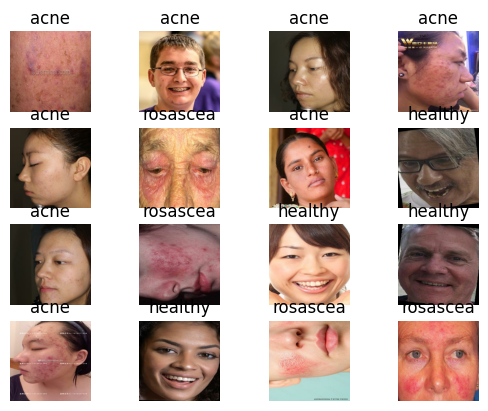

In [ ]:
import matplotlib.pyplot as plt
CLASS_NAMES = CONFIGURATION["CLASS_NAMES"]
for images,labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()])
    plt.axis("off")

In [ ]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset = (
    validation_dataset
   .prefetch(tf.data.AUTOTUNE)
)

testing_dataset = (
    test_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
from tensorflow.keras.layers import Resizing,Rescaling
IM_SIZE = 380
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE,IM_SIZE),
    Rescaling(1./255),
])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint to save the best weights
checkpoint_callback = ModelCheckpoint(
    filepath='best_weights_multiclass.keras',  # Save weights in a clear filename
    monitor='val_binary_accuracy',                # Monitor validation accuracy
    mode='max',                            # Maximize validation accuracy
    verbose=1,                             # Display messages when saving
    save_best_only=True                    # Save only the best weights
)

# EarlyStopping to stop training early when no improvement
early_stopping_callback = EarlyStopping(
    monitor='val_binary_accuracy',      # Monitor validation accuracy
    mode='max',                  # Maximize validation accuracy
    patience=20,                  # Number of epochs with no improvement to wait
    verbose=1,                   # Display messages when stopping
    restore_best_weights=True    # Restore the best weights after stopping
)

# Combine both callbacks
callbacks = [checkpoint_callback, early_stopping_callback]

lr_scheduler = ReduceLROnPlateau(
    monitor='val_binary_accuracy',
    factor=0.5,
    patience=3,  # Reduce LR after 3 epochs of no improvement
    min_lr=1e-7
)

callbacks.append(lr_scheduler)


In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy

loss_function = BinaryCrossentropy()


In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras import Sequential

backbone = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
)

backbone.trainable = True
for layer in backbone.layers[:-20]:
    layer.trainable = False

pretrained_model = Sequential([
    Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION["N_DENSE_1"], activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(CONFIGURATION["N_DENSE_2"], activation="relu"),
    BatchNormalization(),
    Dense(CONFIGURATION["NUM_CLASSES"], activation="sigmoid")  # ✅ changed from softmax to sigmoid
])


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
import tensorflow as tf

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

metrics = [
    BinaryAccuracy(name='binary_accuracy'),  # ✅ For multilabel binary targets
    Precision(name="precision"),
    Recall(name="recall"),
    F1Score(name="f1_score")
]


In [ ]:
pretrained_model.compile(
    optimizer=Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = pretrained_model.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    callbacks = checkpoint_callback
)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - binary_accuracy: 0.8375 - f1_score: 0.7814 - loss: 0.3645 - precision: 0.7256 - recall: 0.8497
Epoch 1: val_binary_accuracy improved from -inf to 0.97106, saving model to best_weights_multiclass.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 266ms/step - binary_accuracy: 0.8377 - f1_score: 0.7816 - loss: 0.3641 - precision: 0.7259 - recall: 0.8498 - val_binary_accuracy: 0.9711 - val_f1_score: 0.9565 - val_loss: 0.0924 - val_precision: 0.9581 - val_recall: 0.9550
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - binary_accuracy: 0.9527 - f1_score: 0.9289 - loss: 0.1391 - precision: 0.9322 - recall: 0.9256
Epoch 2: val_binary_accuracy improved from 0.97106 to 0.98124, saving model to best_weights_multiclass.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - binary_accuracy: 0.9527 - f1_score: 0.9289 - loss: 0.1391 - precision: 0.9322 - recall: 0.9256 - val_binary_accuracy: 0.9812 - val_f1_score: 0.9718 - val_loss: 0.0615 - val_pre

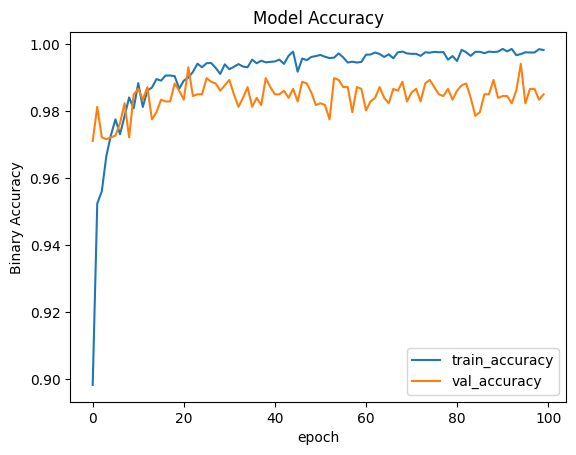

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

Confusion Matrix:
 [[200   8   1]
 [  6 202   0]
 [  0   0 215]]


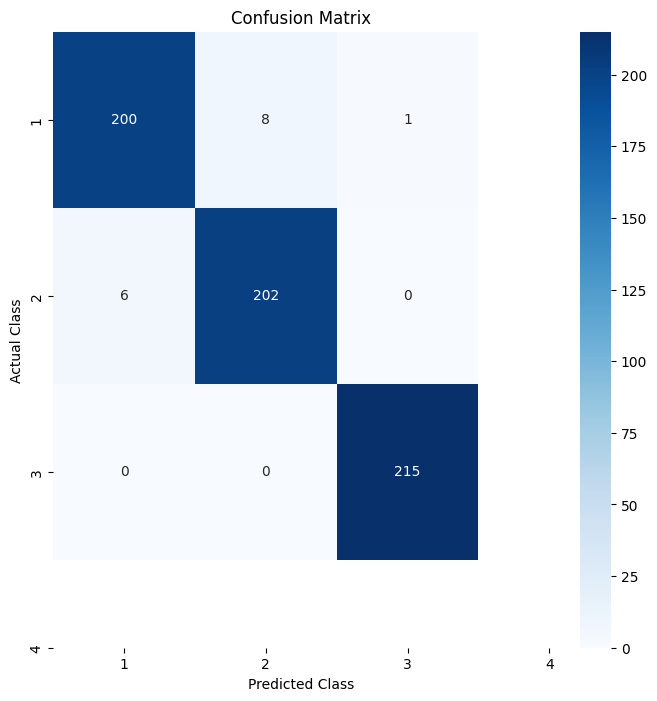

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predicted = []
labels = []

# Iterate through validation data
for images, label in testing_dataset:
    # Get predictions for the batch
    batch_preds = pretrained_model(images, training=False)

    # Convert probabilities to class labels (argmax to get class index)
    batch_preds = np.argmax(batch_preds.numpy(), axis=1)
    predicted.extend(batch_preds)  # Collect all predictions

    # Flatten and collect true labels
    labels.extend(np.argmax(label.numpy(), axis=1))  # Ensure labels are in class index form

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predicted)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix as a heatmap with indices starting from 1
plt.figure(figsize=(8, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=range(1, 5),  # Change range to start from 1
    yticklabels=range(1, 5)   # Change range to start from 1
)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


In [ ]:
pretrained_model.save("/content/drive/MyDrive/efficientNetB7_finetuned_26APril.keras")

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Metric
import tensorflow as tf

# Define the custom F1Score metric if it was used during training
class F1Score(Metric):
    def __init__(self, name='f1_score', dtype=None):
        super(F1Score, self).__init__(name=name, dtype=dtype)
        self.true_positive = self.add_weight(name="tp", initializer="zeros")
        self.false_positive = self.add_weight(name="fp", initializer="zeros")
        self.false_negative = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)  # Convert predictions to binary (0 or 1)
        tp = tf.count_nonzero(y_true * y_pred)
        fp = tf.count_nonzero((y_pred) * (y_true - 1))
        fn = tf.count_nonzero((y_true) * (y_pred - 1))

        self.true_positive.assign_add(tp)
        self.false_positive.assign_add(fp)
        self.false_negative.assign_add(fn)

    def result(self):
        precision = self.true_positive / (self.true_positive + self.false_positive)
        recall = self.true_positive / (self.true_positive + self.false_negative)
        return 2 * (precision * recall) / (precision + recall)

    def reset_state(self):
        self.true_positive.assign(0)
        self.false_positive.assign(0)
        self.false_negative.assign(0)

# Load the model with the custom metric
model_path = "/content/best_weights_multiclass (1).keras"
model = load_model(model_path, custom_objects={"F1Score": F1Score})

# Continue with the evaluation of the model on datasets


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predicted = []
labels = []

# Iterate through validation data
for images, label in training_dataset:
    # Get predictions for the batch
    batch_preds = model(images, training=False)

    # Convert probabilities to class labels (argmax to get class index)
    batch_preds = np.argmax(batch_preds.numpy(), axis=1)
    predicted.extend(batch_preds)  # Collect all predictions

    # Flatten and collect true labels
    labels.extend(np.argmax(label.numpy(), axis=1))  # Ensure labels are in class index form

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predicted)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix as a heatmap with indices starting from 1
plt.figure(figsize=(8, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=range(1, 5),  # Change range to start from 1
    yticklabels=range(1, 5)   # Change range to start from 1
)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predicted = []
labels = []

# Iterate through validation data
for images, label in testing_dataset:
    # Get predictions for the batch
    batch_preds = model(images, training=False)

    # Convert probabilities to class labels (argmax to get class index)
    batch_preds = np.argmax(batch_preds.numpy(), axis=1)
    predicted.extend(batch_preds)  # Collect all predictions

    # Flatten and collect true labels
    labels.extend(np.argmax(label.numpy(), axis=1))  # Ensure labels are in class index form

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predicted)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix as a heatmap with indices starting from 1
plt.figure(figsize=(8, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=range(1, 5),  # Change range to start from 1
    yticklabels=range(1, 5)   # Change range to start from 1
)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


In [ ]:
import tensorflow as tf
import tf2onnx
import onnxruntime as rt
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Metric
from PIL import Image

# Define custom F1Score metric for the model
class F1Score(Metric):
    def __init__(self, name='f1_score', dtype=None):
        super(F1Score, self).__init__(name=name, dtype=dtype)
        self.true_positive = self.add_weight(name="tp", initializer="zeros")
        self.false_positive = self.add_weight(name="fp", initializer="zeros")
        self.false_negative = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        tp = tf.count_nonzero(y_true * y_pred)
        fp = tf.count_nonzero((y_pred) * (y_true - 1))
        fn = tf.count_nonzero((y_true) * (y_pred - 1))

        self.true_positive.assign_add(tp)
        self.false_positive.assign_add(fp)
        self.false_negative.assign_add(fn)

    def result(self):
        precision = self.true_positive / (self.true_positive + self.false_positive)
        recall = self.true_positive / (self.true_positive + self.false_negative)
        return 2 * (precision * recall) / (precision + recall)

    def reset_state(self):
        self.true_positive.assign(0)
        self.false_positive.assign(0)
        self.false_negative.assign(0)

# Load the Keras model
model_path = "/content/drive/MyDrive/efficientNetB7_finetuned_4_class_2_29Jan.keras"
model = load_model(model_path, custom_objects={"F1Score": F1Score})

# Define the input signature for the model
spec = (tf.TensorSpec((None, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3), tf.float32, name="input"),)

# Set the output path for the ONNX model
output_path = "4_class_model.onnx"

# Manually set output names to avoid the missing output_names error
model._output_names = ['output']  # Add the output name to the model

# Convert the Keras model to ONNX format using tf2onnx
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)

# Set up ONNX runtime for inference
providers = ['CPUExecutionProvider']
sess = rt.InferenceSession(output_path, providers=providers)


AttributeError: 'Sequential' object has no attribute 'output_names'

In [ ]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tf2onnx
import onnxruntime as rt
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Metric
from PIL import Image

# Define custom F1Score metric for the model
class F1Score(Metric):
    def __init__(self, name='f1_score', dtype=None):
        super(F1Score, self).__init__(name=name, dtype=dtype)
        self.true_positive = self.add_weight(name="tp", initializer="zeros")
        self.false_positive = self.add_weight(name="fp", initializer="zeros")
        self.false_negative = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        tp = tf.count_nonzero(y_true * y_pred)
        fp = tf.count_nonzero((y_pred) * (y_true - 1))
        fn = tf.count_nonzero((y_true) * (y_pred - 1))

        self.true_positive.assign_add(tp)
        self.false_positive.assign_add(fp)
        self.false_negative.assign_add(fn)

    def result(self):
        precision = self.true_positive / (self.true_positive + self.false_positive)
        recall = self.true_positive / (self.true_positive + self.false_negative)
        return 2 * (precision * recall) / (precision + recall)

    def reset_state(self):
        self.true_positive.assign(0)
        self.false_positive.assign(0)
        self.false_negative.assign(0)

# Load the Keras model
model_path = "/content/drive/MyDrive/efficientNetB7_finetuned_4_class_2_29Jan.keras"
model = load_model(model_path, custom_objects={"F1Score": F1Score})

# Define the input signature for the model
input_signature = (tf.TensorSpec((None, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3), tf.float32, name="input"),)

# Set the output path for the ONNX model
output_path = "4_class_model.onnx"

# Convert the Keras model to ONNX format using tf2onnx
# Use a function to trace the model and generate the graph
@tf.function(input_signature=[tf.TensorSpec(shape=[None, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3], dtype=tf.float32, name="input")])
def model_func(x):
    return model(x)

# Convert the traced model to ONNX
onnx_model = tf2onnx.convert.from_function(model_func, input_signature=input_signature, opset=13, output_path=output_path)

# Set up ONNX runtime for inference
providers = ['CPUExecutionProvider']
sess = rt.InferenceSession(output_path, providers=providers)


In [ ]:
providers = ['CPUExecutionProvider']
sess = rt.InferenceSession("/content/4_class_model.onnx", providers=providers)
def accuracy(model):
  total, acc = 0,0
  for im, label in validation_dataset:
    onnx_pred = model.run(output_names, {"input": np.array(im)})

    if(int(np.argmax(onnx_pred, axis = -1)[0][0]) == int(np.argmax(label, axis = -1)[0])):
      acc += 1

    total += 1
  return acc/total

In [ ]:
accuracy(sess)

NameError: name 'output_names' is not defined

In [ ]:
import numpy as np

def accuracy(model, validation_dataset):
    total, acc = 0, 0
    # Get output names from the ONNX model
    output_names = [output.name for output in model.get_outputs()]

    for im, label in validation_dataset:
        # Run the model with the input data
        onnx_pred = model.run(output_names, {"input": np.array(im)})

        # Compare the predicted label with the true label
        if int(np.argmax(onnx_pred[0], axis=-1)) == int(np.argmax(label, axis=-1)[0]):
            acc += 1

        total += 1

    return acc / total

# Example usage:
accuracy(sess, validation_dataset)


ValueError: Required inputs (['sequential_1/efficientnetb7_1/normalization_1/Sub/y:0', 'sequential_1/efficientnetb7_1/normalization_1/Sqrt/x:0']) are missing from input feed (['input']).

In [ ]:
import numpy as np

def accuracy(model, validation_dataset):
    total, acc = 0, 0
    # Get output names from the ONNX model
    output_names = [output.name for output in model.get_outputs()]

    # Get the input names for normalization (if needed)
    input_names = [input.name for input in model.get_inputs()]

    # Check if additional inputs for normalization are required
    normalization_input_names = [name for name in input_names if 'normalization' in name]

    # Normalization parameters (mean and std for EfficientNet or similar models)
    normalization_params = {
        'mean': np.array([0.485, 0.456, 0.406]),  # Example mean values for EfficientNet
        'std': np.array([0.229, 0.224, 0.225])   # Example std values for EfficientNet
    }

    for im, label in validation_dataset:
        # Preprocess the input image (normalize it)
        im = (im - normalization_params['mean']) / normalization_params['std']

        # Prepare the input feed for the model
        input_feed = {"input": np.array(im)}

        # Add the normalization inputs if required
        for name in normalization_input_names:
            if 'Sub' in name:
                input_feed[name] = normalization_params['mean']
            elif 'Sqrt' in name:
                input_feed[name] = normalization_params['std']

        # Run the model with the input data
        onnx_pred = model.run(output_names, input_feed)

        # Compare the predicted label with the true label
        if int(np.argmax(onnx_pred[0], axis=-1)) == int(np.argmax(label, axis=-1)[0]):
            acc += 1

        total += 1

    return acc / total

# Example usage:
accuracy(sess, validation_dataset)


InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Unexpected input data type. Actual: (tensor(double)) , expected: (tensor(float))

In [ ]:
import numpy as np

def accuracy(model, validation_dataset):
    total, acc = 0, 0
    # Get output names from the ONNX model
    output_names = [output.name for output in model.get_outputs()]

    for im, label in validation_dataset:
        # Run the model with the input data
        onnx_pred = model.run(output_names, {"input": im})

        # Compare the predicted label with the true label
        if int(np.argmax(onnx_pred[0], axis=-1)) == int(np.argmax(label, axis=-1)[0]):
            acc += 1

        total += 1

    return acc / total

# Example usage:
accuracy(sess, validation_dataset)


ValueError: Required inputs (['sequential_1/efficientnetb7_1/normalization_1/Sub/y:0', 'sequential_1/efficientnetb7_1/normalization_1/Sqrt/x:0']) are missing from input feed (['input']).

In [ ]:
import tf2onnx
import onnxruntime as rt
model_path = "/content/drive/MyDrive/efficientNetB7_finetuned_4_class_2_29Jan.keras"
model = load_model(model_path, custom_objects={"F1Score": F1Score})
spec = (tf.TensorSpec(
    (None, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    tf.float32, name="input"),)

output_path = "4class_keras.onnx"

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)


AttributeError: 'Sequential' object has no attribute 'output_names'

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import tensorflow.lite as tflite
from tensorflow.keras.models import load_model

# Load Keras Model without compiling
model_path = "/content/best_weights_multiclass.keras"
model = load_model(model_path, compile=False)

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# **Comment out quantization if unsure about dataset**
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Ensure input/output remain FLOAT32
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Convert & Save
tflite_model = converter.convert()
tflite_model_path = "/content/4_class_convNext.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# ================================
# **Load & Test the TFLite Model**
# ================================

# Image processing


Saved artifact at '/tmp/tmpibgu7njg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  134202598094608: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134202598094416: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134202598095184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134202598096336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134202598096144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134202598093456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134202598095376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134202598093840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134202598094800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134202598095760: TensorSpec(shape=(), dtype=tf.resource, name=None)